# FashionMNIST cGAN 모델 추론 (Inference)


# 1. 환경 설정 및 Google Drive 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
MODEL_DIR = '/content/drive/MyDrive/codeit_sprint/sprint_mission/16/model'
print("✅ Drive Mounted & Path Set:", MODEL_DIR)

✅ Drive Mounted & Path Set: /content/drive/MyDrive/codeit_sprint/sprint_mission/16/model


# 2. 라이브러리 import

In [3]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort

# 3. Generation 구조 정의

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, embedding_dim, num_classes, img_channels=1, feature_maps=128):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.init_size = 8
        self.feature_maps = feature_maps

        self.linear1 = nn.Sequential(
            nn.Linear(z_dim + embedding_dim, feature_maps * self.init_size ** 2),
            nn.BatchNorm1d(feature_maps * self.init_size ** 2),
            nn.ReLU(True)
        )

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps, feature_maps // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(feature_maps // 2, momentum=0.8),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(feature_maps // 2, feature_maps // 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(feature_maps // 4, momentum=0.8),
            nn.ReLU(True),

            nn.Conv2d(feature_maps // 4, img_channels, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        out = self.linear1(x)
        out = out.view(out.size(0), self.feature_maps, self.init_size, self.init_size)
        return self.conv_blocks(out)


# 4. 모델 로드 (PyTorch / Quantized / ONNX)


In [6]:
z_dim, embedding_dim, num_classes = 100, 10, 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [9]:
# PyTorch (기본)
G_pth = Generator(z_dim, embedding_dim, num_classes).to(device)
G_pth.load_state_dict(torch.load(f"{MODEL_DIR}/cgan_gen.pth", map_location=device))
G_pth.eval()

Generator(
  (label_emb): Embedding(10, 10)
  (linear1): Sequential(
    (0): Linear(in_features=110, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
    (9): Tanh()
  )
)

In [11]:
# ONNX (세션 로드)
onnx_path = f"{MODEL_DIR}/cgan_gen.onnx"
onnx_sess = ort.InferenceSession(onnx_path)
print("✅ 모든 모델 로드 완료!")


✅ 모든 모델 로드 완료!


# 6. 테스트용 입력 생성

In [18]:
# 특정 클래스(label)에 대해 이미지 생성 (예: 0 = T-shirt, 9 = Ankle boot)

target_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
z = torch.randn(len(target_labels), z_dim)
y = torch.tensor(target_labels)

print("✅ 테스트 입력 준비 완료!")

✅ 테스트 입력 준비 완료!


In [19]:
with torch.no_grad():
    out_pth = G_pth(z.to(device), y.to(device)).detach().cpu()

# ONNX inference
z_onnx = z.numpy().astype(np.float32)
y_onnx = y.numpy().astype(np.int64)
out_onnx = onnx_sess.run(['img'], {'z': z_onnx, 'y': y_onnx})[0]

In [20]:
# 출력 유사도(MSE) 계산
mse_pth_onnx = np.mean((out_pth.numpy() - out_onnx) ** 2)

print(f"🎯 PyTorch ↔ ONNX MSE: {mse_pth_onnx:.8f}")


🎯 PyTorch ↔ ONNX MSE: 0.00000000


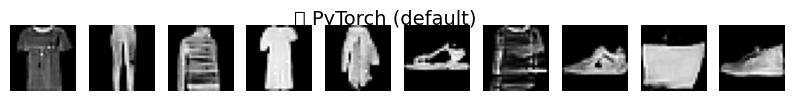

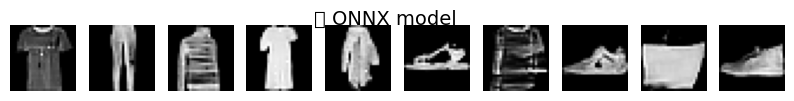

✅ 추론 및 시각화 완료!


In [23]:
# ## 8️⃣ 결과 시각화
def show_images(imgs, title, ncols=10):
    imgs = (imgs + 1) / 2  # Tanh 결과 [-1,1] → [0,1]
    nrows = (len(imgs) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    fig.suptitle(title, fontsize=14)
    for i, ax in enumerate(axes.flat):
        if i < len(imgs):
            ax.imshow(imgs[i][0], cmap='gray')
            ax.axis('off')
        else:
            ax.remove()
    plt.show()

show_images(out_pth, "🧩 PyTorch (default)")
show_images(out_onnx, "🔗 ONNX model")

print("✅ 추론 및 시각화 완료!")